<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

**Цель:** - Подготовить модель машинного обучения для предскаазания коэффициента восстановления золота из золотосодержащей руды. Доступны данные с параметрами добычи и очистки. Модель необходима для оптимизации производства.

**Задачи:**

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

### Описание данных

- Наименование признаков:
  - `[этап].[тип_параметра].[название_параметра]`
    **Пример:** `rougher.input.feed_ag`
- Возможные значения для блока [этап]:
  - rougher — флотация
  - primary_cleaner — первичная очистка
  - secondary_cleaner — вторичная очистка
  - final — финальные характеристики
- Возможные значения для блока [тип_параметра]:
  - input — параметры сырья
  - output — параметры продукта
  - state — параметры, характеризующие текущее состояние этапа
  - calculation — расчётные характеристики
- Параметры этапов:
  - air amount — объём воздуха
  - fluid levels — уровень жидкости
  - feed size — размер гранул сырья
  - feed rate — скорость подачи

**План выполнения работы:**

- Подготовка Данных
     - Изучение данных
     - Проверка расчётов эффективности обогащения
     - Анализ признаков, недоступных в тестовой выборке
     - Предобработка данных
- Анализ данных
     - Анализ изменения концентрации металлов (Au, Ag, Pb)
     - Сравнение распределений размеров гранул сырья
     - Исследование суммарных концентраций веществ
- Модель
     - Функция итоговой sMAPE
     - Обучение и оценка качества моделей
     - Тестирование модели
- Общий вывод

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.scorer import make_scorer

In [2]:
df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

<b>Определение эффективности рассчета признака обогащения на обучающей выборке</b>

<i>Создание функции рассчета эффективности обогащения</i>

In [3]:
def recovery(C, F, T):
    recovery = (C * (F - T)) / (F * (C - T))
    return recovery

In [4]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

In [5]:
recovery = recovery(C, F, T) * 100

<i>Нахождение MAE</i>

In [6]:
mean_absolute_error(df_train['rougher.output.recovery'], recovery)

9.682896147825551e-15

<b>Вывод</b>

Значение MAE предельно мало, поэтому можно сделать вывод, что рассчет признака обогащения в обучающей выборке достаточно точен.

<b>Анализ признаков, не доступных в тестовой выборке</b>

In [7]:
non_columns_df_test = []
count = 0
for item in df_train.columns:
    if item not in df_test.columns:
        non_columns_df_test.append(item)
        count += 1
print(non_columns_df_test)
print()
print('Всего отсутствует параметров в тестовой выборке: ', count)

['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tai

<b>Вывод</b>

В тестовой выборке отсутсвует 34 параметра с типом "параметры продукта" и "расчётные характеристики". Также в тестовой выборке нет целевых признаков rougher.output.recovery и final.output.recovery. Данные параметры отсутствуют в тестовой выборке, так как вычисляются позднее.

<b>Предобработка данных</b>

<i>Просмотр информации из файлов и поиск дубликатов</i>

In [8]:
data_dict = {'train': df_train, 
             'test': df_test, 
             'full': df_full}

In [9]:
for key, value in data_dict.items():
    value.info()
    print('Количество дубликатов: ', value.duplicated().sum())
    print('\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
date                                                  14149 non-null object
final.output.concentrate_ag                           14148 non-null float64
final.output.concentrate_pb                           14148 non-null float64
final.output.concentrate_sol                          13938 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14049 non-null float64
final.output.tail_sol                                 14144 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14129 non-null float64
primary_cleaner.input.depressant             

<i>Изменение размеров тренивочной и тестовой выборок</i>

In [10]:
df_train = df_train.drop(['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tail_au', 'secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_au'], axis=1)

In [11]:
df_test = df_test.merge(df_full[['date', 'rougher.output.recovery', 'final.output.recovery']], how = 'left', on = 'date')

In [12]:
df_train.shape, df_test.shape

((14149, 55), (5290, 55))

<div class="alert alert-block alert-info">Обработка пропущенных значений</div>

In [13]:
df_full.dropna(inplace = True)
df_train.dropna(inplace = True)
df_test.dropna(inplace = True)

<b>Вывод</b>

Дублткаты в данных отсутствуют, но есть пропущенные значения. Возможная причина пропущенных значений - отсутствие концентрата металла, флотационных реагентов в технологическом процессе. Для того, чтобы в дальнейшем не исказить результат работы модели, строки с пропущенными значениями были удалены.  
Для возможности моделирования тренировочная и тестовые выборки были приведены к одному размеру: из тренировочной удалены признаки, отсутствующие в тестовой выборке, а в тестовую выборку из исходных данных добавлены целевые признаки.

## Анализ данных

<b>Анализ изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки</b>

In [15]:
metal = ['Au', 'Ag', 'Pb']

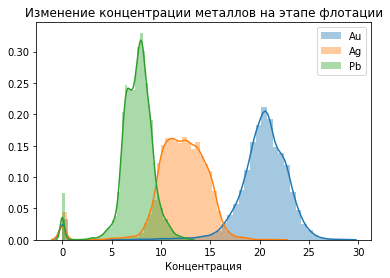

In [16]:
for item in ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']:
    sns.distplot(df_full[item])
    plt.title('Изменение концентрации металлов на этапе флотации')
    plt.xlabel('Концентрация')
    plt.legend(metal)

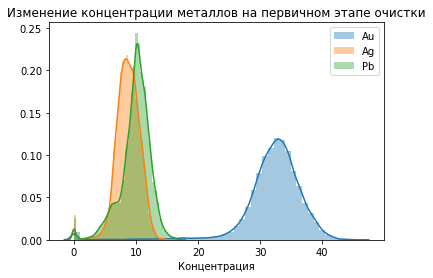

In [17]:
for item in ['primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb']:
    sns.distplot(df_full[item])
    plt.title('Изменение концентрации металлов на первичном этапе очистки')
    plt.xlabel('Концентрация')
    plt.legend(metal)

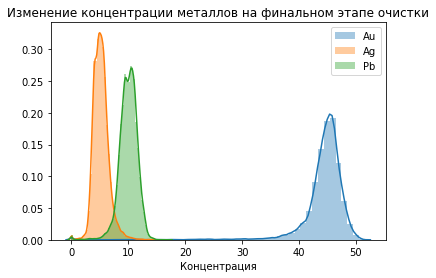

In [18]:
for item in ['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']:
    sns.distplot(df_full[item])
    plt.title('Изменение концентрации металлов на финальном этапе очистки')
    plt.xlabel('Концентрация')
    plt.legend(metal)

<b>Вывод</b>

Концентрация золота увеличивается после каждого этапа очискти, концентрация серебра, наоборот, снижается. Концентрация свинца увеличивается после флотация, но после первичной очистки существенно не меняется.

<b>Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках</b>

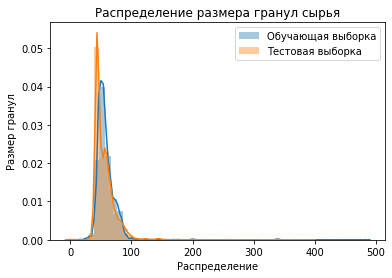

In [19]:
sns.distplot(df_train['rougher.input.feed_size'], label='Обучающая выборка')
sns.distplot(df_test['rougher.input.feed_size'], label='Тестовая выборка')
plt.title('Распределение размера гранул сырья')
plt.xlabel('Распределение')
plt.ylabel('Размер гранул')
plt.legend()
plt.show()

<b>Вывод</b>

Распределение размеров гранул сырья на обучающей и тестовых выборках достаточно близки.

<b>Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах</b>

In [20]:
rougher_input_feed_sum = df_full['rougher.input.feed_ag']+df_full['rougher.input.feed_pb']+df_full['rougher.input.feed_sol']+df_full['rougher.input.feed_au']
rougher_output_concentrate = df_full['rougher.output.concentrate_ag']+df_full['rougher.output.concentrate_pb']+df_full['rougher.output.concentrate_sol']+df_full['rougher.output.concentrate_au']
final_output_concentrate = df_full['final.output.concentrate_ag']+df_full['final.output.concentrate_pb']+df_full['final.output.concentrate_sol']+df_full['final.output.concentrate_au']


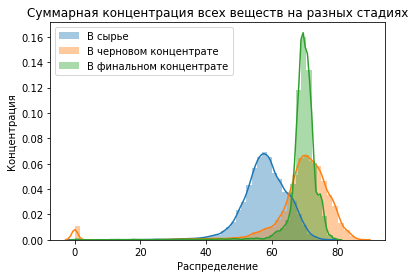

In [21]:
sns.distplot(rougher_input_feed_sum, label='В сырье')
sns.distplot(rougher_output_concentrate, label='В черновом концентрате')
sns.distplot(final_output_concentrate, label='В финальном концентрате')
plt.title('Суммарная концентрация всех веществ на разных стадиях')
plt.xlabel('Распределение')
plt.ylabel('Концентрация')
plt.legend()
plt.show()

In [22]:
df_full_copy = df_full

In [23]:
df_full_copy['rougher_input_feed_sum'] = rougher_input_feed_sum
df_full_copy['rougher_output_concentrate'] = rougher_output_concentrate
df_full_copy['final_output_concentrate'] = final_output_concentrate

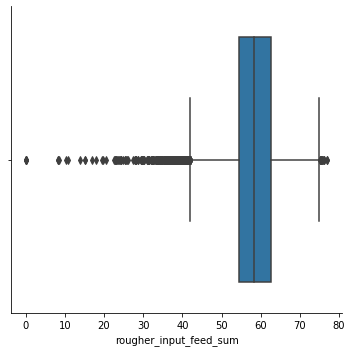

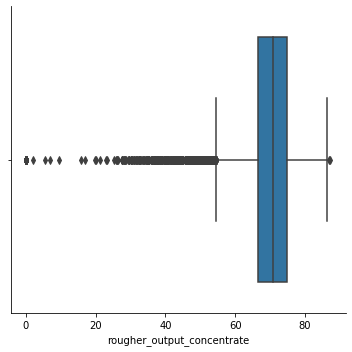

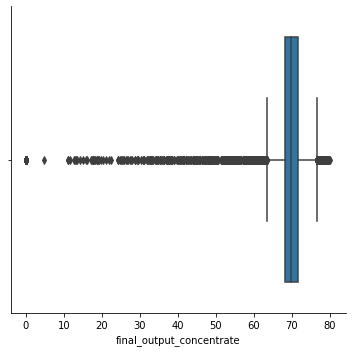

In [24]:
for item in ['rougher_input_feed_sum', 'rougher_output_concentrate', 'final_output_concentrate']:
    sns.catplot(x = item, kind = 'box', data = df_full_copy)

<div class="alert alert-block alert-info">На диаграммах, представленных выше, видим, что в выборке присутствуют нулевые суммарные концентрации, являющиеся выбросами (аномальными значениями), избавимся от них, дабы не исказить в дальнейшем работу модели.</div>

<b>Избавление от аномальных значений</b>

In [25]:
df_full = df_full[
    (df_full['rougher.input.feed_ag'] + 
    df_full['rougher.input.feed_pb'] + 
    df_full['rougher.input.feed_sol'] + 
    df_full['rougher.input.feed_au']) > 0
] 

df_full = df_full[
    (df_full['rougher.output.concentrate_ag'] + 
    df_full['rougher.output.concentrate_pb'] + 
    df_full['rougher.output.concentrate_sol'] + 
    df_full['rougher.output.concentrate_au']) > 0
]

df_full = df_full[
    (df_full['final.output.concentrate_ag'] + 
    df_full['final.output.concentrate_pb'] + 
    df_full['final.output.concentrate_sol'] + 
    df_full['final.output.concentrate_au']) > 0
]

In [26]:
rougher_input_feed_sum_clean = df_full['rougher.input.feed_ag']+df_full['rougher.input.feed_pb']+df_full['rougher.input.feed_sol']+df_full['rougher.input.feed_au']
rougher_output_concentrate_clean = df_full['rougher.output.concentrate_ag']+df_full['rougher.output.concentrate_pb']+df_full['rougher.output.concentrate_sol']+df_full['rougher.output.concentrate_au']
final_output_concentrate_clean = df_full['final.output.concentrate_ag']+df_full['final.output.concentrate_pb']+df_full['final.output.concentrate_sol']+df_full['final.output.concentrate_au']


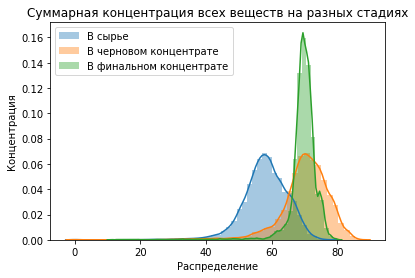

In [27]:
sns.distplot(rougher_input_feed_sum_clean, label='В сырье')
sns.distplot(rougher_output_concentrate_clean, label='В черновом концентрате')
sns.distplot(final_output_concentrate_clean, label='В финальном концентрате')
plt.title('Суммарная концентрация всех веществ на разных стадиях')
plt.xlabel('Распределение')
plt.ylabel('Концентрация')
plt.legend()
plt.show()

<b>Вывод</b>

Для показателя суммарной концентрации всех веществ исключены нулевые суммарные концентрации.

## Модель

<b>Функция для вычисления итоговой sMAPE</b>

In [28]:
def sMAPE(y_target, y_pred):
    return ((1/len(y_target))*np.sum(2*np.abs(y_target-y_pred)/(np.abs(y_target)+np.abs(y_pred))))*100

In [29]:
def sMAPE_final(sMAPE_rougher, sMAPE_final):
    return (0.25*sMAPE_rougher + 0.75*sMAPE_final)

<b>Обучение моделей и оценка их качества кросс-валидацией</b>

In [30]:
state=np.random.RandomState(12345)

In [31]:
target_rougher_train = df_train['rougher.output.recovery']
target_final_train = df_train['final.output.recovery']
features_train = df_train.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

target_rougher_test = df_test['rougher.output.recovery']
target_final_test = df_test['final.output.recovery']
features_test = df_test.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

In [32]:
features_train.shape, features_test.shape

((12679, 52), (5229, 52))

In [33]:
numeric = features_train.columns
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [34]:
cv = 5

In [35]:
models = [DecisionTreeRegressor(random_state = state), 
          RandomForestRegressor(random_state = state, n_estimators = 20, max_depth = 5), 
          LinearRegression()]

In [36]:
cross_val_result = []

for model in models:     
    scorer = make_scorer(sMAPE, greater_is_better=False)     
    cross_val_score_rougher = cross_val_score(model, features_train, target_rougher_train, cv=cv, scoring=scorer).mean()
    cross_val_score_final = cross_val_score(model, features_train, target_final_train, cv=cv, scoring=scorer).mean()
    cross_val_result.append({'model name': model.__class__.__name__, 
                              'cross_val_score_rougher': cross_val_score_rougher, 
                              'cross_val_score_final': cross_val_score_final}) 
              
pd.DataFrame(cross_val_result)

,model name,cross_val_score_rougher,cross_val_score_final
0,DecisionTreeRegressor,-22.247380,-21.823533
1,RandomForestRegressor,-10.497059,-9.455540
2,LinearRegression,-10.849083,-10.960082


Наилучшее качество показала модель Случайного леса. Обучим ее и протестируем.

In [37]:
model_forest_rougher = RandomForestRegressor(random_state=state, n_estimators=20, max_depth=5)
model_forest_rougher.fit(features_train, target_rougher_train)

model_forest_final = RandomForestRegressor(random_state=state, n_estimators=20, max_depth=5)
model_forest_final.fit(features_train, target_final_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False,
                      random_state=RandomState(MT19937) at 0x7FDB1D2117C0,
                      verbose=0, warm_start=False)

<b>Проверка модели на тестовой выборке</b>

In [38]:
predict_rougher = model_forest_rougher.predict(features_test)
predict_final = model_forest_final.predict(features_test)

In [39]:
smape_rougher = sMAPE(target_rougher_test, predict_rougher)
smape_final = sMAPE(target_final_test, predict_final)

print('Итоговое sMAPE:', sMAPE_final(smape_rougher, smape_final))

Итоговое sMAPE: 9.560699989215792


<b>Оценка модели на адекватность</b>

In [40]:
dummy_reg = DummyRegressor(strategy='mean')

dummy_reg.fit(features_train, target_rougher_train)
predictions_rougher_dr = dummy_reg.predict(features_test)

dummy_reg.fit(features_train, target_final_train)
predictions_final_dr = dummy_reg.predict(features_test)

smape_rougher_dr = sMAPE(target_rougher_test, predictions_rougher_dr)
smape_final_dr = sMAPE(target_final_test, predictions_final_dr)

print('Итоговое sMAPE', sMAPE_final(smape_rougher_dr, smape_final_dr))

Итоговое sMAPE 9.744788079141177


Ошибка обученной модели меньше, чем ошибка константной модели, поэтому, можно сдлеать вывод, что модель прошла тест на адекватность. 

<b>Вывод</b>

В ходе анализа данных осуществлена работа по проверке правильности рассчета эффективности обогащения: значение МАЕ между рассчетами на обучающей выборке и значением признака  rougher.output.recovery (эффективность обогащения чернового концентрата) предельно мало, что говорит о точности значений данного признака.  
Выполнен анализ признаков, недоступных в тестовой выборке: в тестовой выборке отсутсвуют признаки с параметрами продуктов (output) и расчетными характеристиками (calculation). Их отсутствие связно с тем, что данные параметры вычисляются значительно позже.  
Выполнена предобработка данных: обработаны пропущенные значения, скорректированы размеры обучающей и тестовой выборок.  
В ходе анализ данных определны следующие закономерности:
- концентрация золота увеличивается после каждого этапа очискти, концентрация серебра, наоборот, снижается; концентрация свинца увеличивается после флотация, но после первичной очистки существенно не меняется;
- наибольшая суммарная концентрация всех веществ получается на финальной стадии очистки сырья;
- распределение размеров гранул сырья на обучающей и тестовых выборках достаточно близки.

Создана функция для рассчета итоговой sMAPE, обучено несколько моделей. Наилучшше качество путем использования кросс-валидации показала работа модели Случайного леса. Итоговая sMAPE обученной модели ниже, чем у константной, что свидетельствует об адекватности обученной модели.